# CNN for emotion/facial detection

## Desription

    -  Images are categorized based on the emotion shown in the facial expressions (happiness, neutral, sadness, anger, surprise, disgust, fear). 

In [2]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# defining dir variables 
root_dir = '../input/emotion-detection-fer/'
train_dir = root_dir + 'train/'
test_dir = root_dir + 'test/'

## Dataset

    The dataset contain 35,685 examples of 48x48 pixel gray scale images of faces divided into train and test dataset.

### Target labels in dataset

In [3]:
target_var = os.listdir(train_dir)
print(target_var)

['fearful', 'disgusted', 'angry', 'neutral', 'sad', 'surprised', 'happy']


### GPU Detection

In [4]:
import torch

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("GPU is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("GPU is NOT available. Using CPU.")

GPU is available!
GPU Name: Tesla P100-PCIE-16GB
CUDA Version: 11.0


In [5]:
# Create a tensor and move it to the GPU
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")  # Use CPU
    print("Using CPU")

x = torch.tensor([1.0, 2.0, 3.0]).to(device)
y = torch.tensor([4.0, 5.0, 6.0]).to(device)
z = x + y

print("Result:", z)
print("Device of result:", z.device)

Using GPU: Tesla P100-PCIE-16GB
Result: tensor([5., 7., 9.], device='cuda:0')
Device of result: cuda:0


### Sample images 

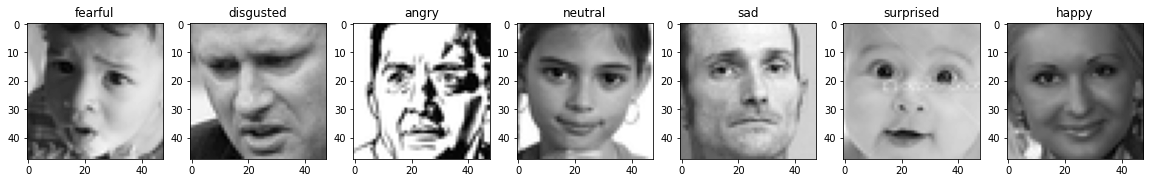

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

fig, axes = plt.subplots(1, 7, figsize=(20,8))
for i in range(len(target_var)):
    img_path = os.path.join(train_dir, target_var[i], os.listdir(os.path.join(train_dir, target_var[i]))[0])
    img = Image.open(img_path)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(target_var[i])
plt.show()

## EDA (Exploring number of images in each class)

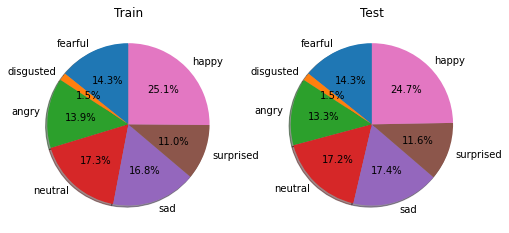

Emotion : fearful
	Training : 4097
	Testing : 1024
Emotion : disgusted
	Training : 436
	Testing : 111
Emotion : angry
	Training : 3995
	Testing : 958
Emotion : neutral
	Training : 4965
	Testing : 1233
Emotion : sad
	Training : 4830
	Testing : 1247
Emotion : surprised
	Training : 3171
	Testing : 831
Emotion : happy
	Training : 7215
	Testing : 1774


In [7]:
x_train = np.array([len(os.listdir(os.path.join(train_dir, i))) for i in target_var])
x_test = np.array([len(os.listdir(os.path.join(test_dir, i))) for i in target_var])
label = target_var

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%', shadow=True, startangle=90)
axes[1].pie(x_test, labels=label, autopct='%1.1f%%', shadow=True, startangle=90)
axes[0].set_title('Train')
axes[1].set_title('Test')
plt.show()

for i in target_var:
    print('Emotion : ' + i)
    print('\tTraining : ' + str(len(os.listdir(os.path.join(train_dir, i)))) + '\n\tTesting : ' + str(len(os.listdir(os.path.join(test_dir, i)))))
    


## Data loading and perprocessing

In [8]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((48, 48)),  
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),  
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Split train dataset into training and validation sets
train_size = int(0.7 * len(train_dataset))  # 70% training, 30% validation
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

# Define data loaders
batch_size = 64

train_loader = DataLoader(
    train_subset,
    batch_size=64,
    shuffle=True,  
    num_workers=4,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_subset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle validation data
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle test data
    num_workers=4,
    pin_memory=True
)

# Print class names
print(train_dataset.classes)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


## Bulding model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes=7):
        super(CNNModel, self).__init__()
        
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.2)
        
        # Convolutional Block 2
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.2)
        
        # Convolutional Block 3
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.2)
        
        # Convolutional Block 4
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn8 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(0.2)
        
        # Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 3 * 3, 64)  # Adjust input size based on the final feature map size
        self.bn9 = nn.BatchNorm1d(64)
        self.dropout5 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(64, 64)
        self.bn10 = nn.BatchNorm1d(64)
        self.dropout6 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Block 4
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        x = self.dropout4(x)
        
        # Fully Connected Layers
        x = self.flatten(x)
        x = F.relu(self.bn9(self.fc1(x)))
        x = self.dropout5(x)
        
        x = F.relu(self.bn10(self.fc2(x)))
        x = self.dropout6(x)
        
        x = self.fc3(x)
        return F.softmax(x, dim=1)

# Create the model
model = CNNModel(num_classes=7)

# Print the model summary
print(model)


CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), paddi

### Compile and run

In [10]:
import torch.nn as nn
import torch.optim as optim

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Define loss function s
criterion = nn.CrossEntropyLoss()  

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Adam optimizer with learning rate 0.0005

train_loader = DataLoader(
    train_subset,
    batch_size=64,
    shuffle=True,  # Use shuffle instead of sampler
    num_workers=4,
    pin_memory=True
)

# Training loop
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Calculate training metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100.0 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    # Calculate validation metrics
    val_loss = val_running_loss / len(valid_loader)
    val_accuracy = 100.0 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch results
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

print("Training finished.")

Using device: cuda
Epoch [1/50], Train Loss: 1.8545, Train Acc: 30.15%, Val Loss: 1.7567, Val Acc: 40.67%
Epoch [2/50], Train Loss: 1.7404, Train Acc: 42.63%, Val Loss: 1.7078, Val Acc: 45.26%
Epoch [3/50], Train Loss: 1.6997, Train Acc: 46.30%, Val Loss: 1.6860, Val Acc: 46.96%
Epoch [4/50], Train Loss: 1.6831, Train Acc: 47.78%, Val Loss: 1.6668, Val Acc: 49.12%
Epoch [5/50], Train Loss: 1.6692, Train Acc: 49.31%, Val Loss: 1.6694, Val Acc: 48.61%
Epoch [6/50], Train Loss: 1.6606, Train Acc: 49.92%, Val Loss: 1.6532, Val Acc: 50.20%
Epoch [7/50], Train Loss: 1.6516, Train Acc: 50.80%, Val Loss: 1.6521, Val Acc: 50.61%
Epoch [8/50], Train Loss: 1.6415, Train Acc: 52.01%, Val Loss: 1.6451, Val Acc: 51.42%
Epoch [9/50], Train Loss: 1.6338, Train Acc: 52.84%, Val Loss: 1.6264, Val Acc: 53.00%
Epoch [10/50], Train Loss: 1.6193, Train Acc: 54.30%, Val Loss: 1.6223, Val Acc: 53.54%
Epoch [11/50], Train Loss: 1.6116, Train Acc: 55.19%, Val Loss: 1.6328, Val Acc: 52.72%
Epoch [12/50], Train L

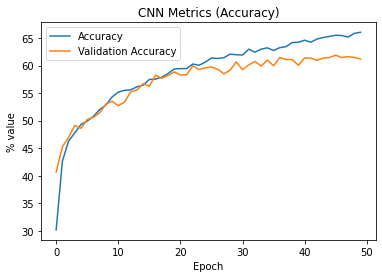

In [11]:
# Plot training and validation accuracy
plt.plot(train_accuracies, label='Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('CNN Metrics (Accuracy)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

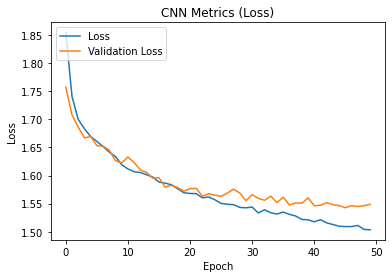

In [12]:
# Plot training and validation loss
plt.plot(train_losses, label='Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('CNN Metrics (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

## Testing and evaluation¶

In [13]:
# Set the model to evaluation mode
model.eval()

# Disable gradient computation
y_preds = []  # List to store all predictions
y_true = []   # List to store all true labels 

with torch.no_grad():
    for inputs, labels in test_loader:  # Iterate over the test_loader
        # Move inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass: compute predictions
        outputs = model(inputs)
        
        # If using a classification model, get the predicted class labels
        _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability
        
        # Collect predictions and true labels
        y_preds.extend(preds.cpu().numpy())  # Move predictions to CPU and convert to numpy
        y_true.extend(labels.cpu().numpy())  # Move true labels to CPU and convert to numpy

# Convert lists to numpy arrays
y_pred = np.array(y_preds)
y_true = np.array(y_true)

print("Predictions:", y_pred)
print("True Labels:", y_true)

Predictions: [0 5 4 ... 6 6 0]
True Labels: [0 0 0 ... 6 6 6]


In [14]:
# Extract true labels from the test dataset
y_actual = [label for _, label in test_dataset]
y_actual = np.array(y_actual)  

In [15]:
### Confusion matrix plot helper function from https://www.kaggle.com/grfiv4/plot-a-confusion-matrix ###
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

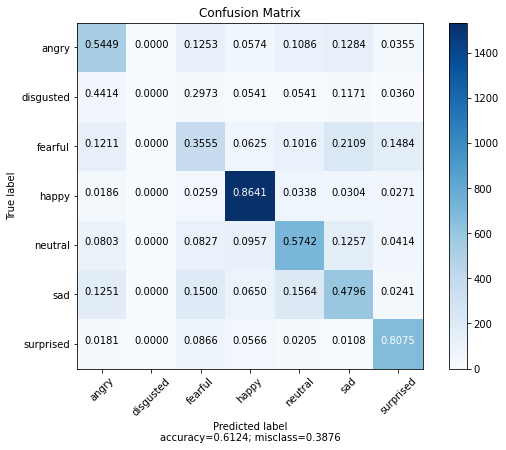

In [16]:
from sklearn import metrics

class_names = train_dataset.classes  

# Compute confusion matrix
cm = metrics.confusion_matrix(y_actual, y_pred)

# Use the custom plot_confusion_matrix function with class_names
plot_confusion_matrix(cm, target_names=class_names, title='Confusion Matrix', normalize=True)

In [17]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_actual, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.5230    0.5449    0.5337       958
           1     0.0000    0.0000    0.0000       111
           2     0.3939    0.3555    0.3737      1024
           3     0.8051    0.8641    0.8336      1774
           4     0.5930    0.5742    0.5834      1233
           5     0.5120    0.4796    0.4952      1247
           6     0.6778    0.8075    0.7370       831

    accuracy                         0.6124      7178
   macro avg     0.5007    0.5180    0.5081      7178
weighted avg     0.5943    0.6124    0.6021      7178



# Tensorflow Implementation (Same CNN Model)

## Data loading and perprocessing

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using IDG to load images from directory
train_idg = ImageDataGenerator(rescale=1./255, validation_split=0.3) # 30 percent validation split for taining 
test_idg = ImageDataGenerator(rescale=1./255)

# Specify parameters/arguments for data generation
img_size = (48, 48)
batch_size = 64

arg_train = {'target_size': img_size,
             'color_mode': 'grayscale',
             'class_mode' : 'categorical',
             'batch_size': batch_size}
arg_test = {'target_size': img_size,
            'color_mode': 'grayscale',
            'class_mode' : 'categorical',
            'batch_size': batch_size,
            'shuffle': False}

train = train_idg.flow_from_directory(directory=train_dir, subset='training', **arg_train)
valid = train_idg.flow_from_directory(directory=train_dir, subset='validation', **arg_train)
test  = test_idg.flow_from_directory(directory=test_dir, **arg_test)

Found 20099 images belonging to 7 classes.
Found 8610 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Buiding Model

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

model = tf.keras.Sequential()

model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(48,48,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(48,48,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(7,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0

### Compile and run

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train ,
    validation_data=valid,
    epochs=50)

Epoch 1/50
315/315 [==============================] - 31s 74ms/step - loss: 2.8938 - accuracy: 0.1721 - val_loss: 1.8491 - val_accuracy: 0.2317
Epoch 2/50
315/315 [==============================] - 24s 78ms/step - loss: 2.1727 - accuracy: 0.2204 - val_loss: 1.7549 - val_accuracy: 0.3074
Epoch 3/50
315/315 [==============================] - 23s 74ms/step - loss: 1.9505 - accuracy: 0.2664 - val_loss: 1.6463 - val_accuracy: 0.3561
Epoch 4/50
315/315 [==============================] - 23s 72ms/step - loss: 1.7712 - accuracy: 0.3134 - val_loss: 1.5561 - val_accuracy: 0.3891
Epoch 5/50
315/315 [==============================] - 25s 79ms/step - loss: 1.6481 - accuracy: 0.3609 - val_loss: 1.4761 - val_accuracy: 0.4230
Epoch 6/50
315/315 [==============================] - 22s 71ms/step - loss: 1.5582 - accuracy: 0.3947 - val_loss: 1.4187 - val_accuracy: 0.4510
Epoch 7/50
315/315 [==============================] - 24s 75ms/step - loss: 1.4824 - accuracy: 0.4336 - val_loss: 1.3669 - val_accuracy:

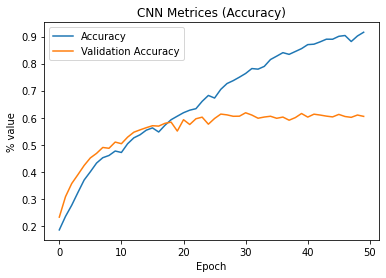

In [21]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Metrices (Accuracy)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

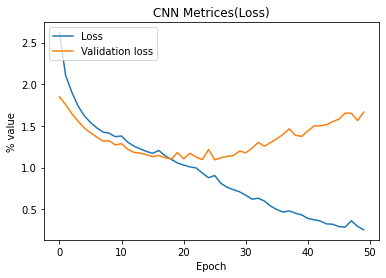

In [22]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('CNN Metrices(Loss)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

## Testing and evaluation¶

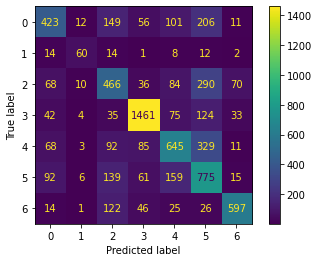

In [23]:
y_pred = model.predict(test)
y_pred_labels = []
for i in y_pred:
    y_pred_labels.append(np.argmax(i))
y_actual = test.classes[test.index_array]

cm = metrics.confusion_matrix(y_actual, y_pred_labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [24]:
print(classification_report(y_actual, y_pred_labels, digits=4))

              precision    recall  f1-score   support

           0     0.5867    0.4415    0.5039       958
           1     0.6250    0.5405    0.5797       111
           2     0.4582    0.4551    0.4566      1024
           3     0.8368    0.8236    0.8301      1774
           4     0.5880    0.5231    0.5536      1233
           5     0.4398    0.6215    0.5151      1247
           6     0.8078    0.7184    0.7605       831

    accuracy                         0.6167      7178
   macro avg     0.6203    0.5891    0.5999      7178
weighted avg     0.6311    0.6167    0.6192      7178

